In [22]:
# Required Packages for Housing Affordability Simulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import random
from datetime import datetime, timedelta
from numpy.random import default_rng
from scipy import stats

# Set random seed for reproducibility
rng = default_rng(42)

In [51]:
# TODO get this data from actual sources
# Simulation parameters
NUM_YEARS = 10  # Simulation runs from 2025 to 2035
NUM_PARCELS = 1000  # Number of land parcels in simulation
NUM_PEOPLE = 2000  # Number of people agents (homeowners and buyers)
NUM_REALIZATIONS = 100  # Number of Monte Carlo realizations (reduced from 1000 for demo)

# Single neighborhood with average characteristics
NEIGHBORHOOD = {"name": "Toronto", "base_land_value": 600000, "density_factor": 2.0}

# Zoning types and their density allowances
ZONING_TYPES = {
    "R": {"name": "Residential", "max_density": 1.0, "redevelopment_threshold": 0.7}
}

# Policy scenarios
POLICY_SCENARIOS = {
    "baseline": {
        "name": "Baseline - Current Zoning",
        "zoning_changes": {},
        "interest_rate_mean": 0.05,
        "interest_rate_std": 0.005,
        "foreign_buyer_tax": 0.15,
        "property_tax_rate": 0.0063,
        "first_time_buyer_incentive": 0.05
    },
    "moderate_upzoning": {
        "name": "Increase Allowed Density by 30%",
        "zoning_changes": {"R": 1.3},
        "interest_rate_mean": 0.045,
        "interest_rate_std": 0.005,
        "foreign_buyer_tax": 0.20,
        "property_tax_rate": 0.0070,
        "first_time_buyer_incentive": 0.10
    },
    "greater_upzoning": {
        "name": "Increase Allowed Density by 50%",
        "zoning_changes": {"R": 1.5},  # Multipliers for allowed density
        "interest_rate_mean": 0.05,
        "interest_rate_std": 0.005,
        "foreign_buyer_tax": 0.15,
        "property_tax_rate": 0.0063,
        "first_time_buyer_incentive": 0.05
    }
}

# Economic parameters
BASELINE_PARAMS = {
    "inflation_rate_mean": 0.025,
    "inflation_rate_std": 0.005,
    "wage_growth_mean": 0.03,
    "wage_growth_std": 0.01,
    "population_growth_rate": 0.015,
    "market_sentiment_volatility": 0.2,
    "construction_cost_inflation": 0.035
}

# Buyer parameters
BUYER_PARAMS = {
    "down_payment_min": 0.05,  # Minimum down payment (5%)
    "down_payment_target": 0.20,  # Target down payment (20%)
    "max_mortgage_payment_ratio": 0.30,  # Maximum 30% of income for mortgage
    "amortization_period": 25,  # 25-year mortgage
    "qualification_buffer": 0.02  # 2% buffer on qualification rate
}

In [60]:
class ParcelAgent:
    """Represents a land parcel in Toronto with housing properties"""
    
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        
        # Initialize base values
        self.land_value = NEIGHBORHOOD["base_land_value"] * (0.9 + 0.2 * rng.random())
        self.improvement_value = self.generate_improvement_value()
        
        # Assign zoning type
        self.zoning_type = "R"
        self.allowed_density = ZONING_TYPES[self.zoning_type]["max_density"]
        self.current_density = self.allowed_density * (0.5 + 0.5 * rng.random())
        
        # Status flags
        self.redevelopment_status = False
        self.years_since_redevelopment = rng.integers(0, 15)  # Random age of property
        self.for_sale = rng.random() < 0.05  # 5% of properties for sale initially
        self.owner_id = None
        self.last_sale_price = None
        self.last_sale_year = None
        
    def generate_improvement_value(self):
        """Generate the improvement value (building) based on neighborhood"""
        base_improvement = NEIGHBORHOOD["base_land_value"] * (0.8 + 0.6 * rng.random())
        return base_improvement
    
    def get_total_value(self):
        """Calculate the total property value"""
        return self.land_value + self.improvement_value
    
    def get_market_price(self, market_sentiment=1.0):
        """Calculate the market price with sentiment factor"""
        base_price = self.get_total_value()
        # Add random market variation and sentiment
        price = base_price * (0.95 + 0.1 * rng.random()) * market_sentiment
        return price
    
    def update_value(self, neighborhood_growth, market_sentiment, year_idx):
        """Update property values based on market conditions"""
        # Land value grows with neighborhood demand
        self.land_value *= (1 + neighborhood_growth)
        
        # Improvement value depreciates with age but can be maintained
        depreciation = 0.01 * (1 - 0.5 * (self.redevelopment_status))
        self.improvement_value *= (1 - depreciation)
        
        # Check for redevelopment opportunity
        self.check_redevelopment(market_sentiment, year_idx)
    
    def check_redevelopment(self, market_sentiment, year_idx):
        """Check if parcel should be redeveloped based on economic conditions"""
        # Calculate land value to total value ratio
        land_ratio = self.land_value / self.get_total_value()
        
        # Get redevelopment threshold for this zoning type
        threshold = ZONING_TYPES[self.zoning_type]["redevelopment_threshold"]
        
        # Adjust threshold based on market sentiment
        adjusted_threshold = threshold * (1 - 0.2 * (market_sentiment - 1))
        
        # Check if redevelopment makes economic sense
        if (land_ratio > adjusted_threshold and 
            self.years_since_redevelopment > 10 and 
            rng.random() < 0.3):  # Probability factor
            
            # Apply redevelopment
            self.redevelopment_status = True
            self.years_since_redevelopment = 0
            
            # Calculate new density based on allowed density and policy
            scenario = self.model.scenario
            density_multiplier = POLICY_SCENARIOS[scenario]["zoning_changes"].get(
                self.zoning_type, 1.0)
            
            # Update density and improvement value
            self.current_density = min(self.allowed_density * density_multiplier, 
                                      self.allowed_density * 1.5)  # Cap at 150% of original
            
            # New improvement value based on construction costs and density
            construction_cost_base = 300000 * (1 + 0.035) ** year_idx  # Base cost with inflation
            self.improvement_value = construction_cost_base * self.current_density
        else:
            self.years_since_redevelopment += 1

class PeopleAgent:
    """Represents a person in the housing market (buyer or homeowner)"""
    
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        
        # Determine role (80% homeowners, 20% buyers initially)
        self.role = "homeowner" if rng.random() < 0.8 else "buyer"
        
        # Financial attributes
        self.age = int(rng.normal(40, 10))  # Age distribution
        self.income = self.generate_income()
        self.savings = self.generate_savings()
        self.net_worth = self.savings
        self.housing_budget = self.calculate_housing_budget()
        
        # Housing status
        self.owns_property = self.role == "homeowner"
        self.property_id = None
        self.years_in_market = 0
        self.mortgage_amount = 0
        self.mortgage_payment = 0
        self.housing_cost_ratio = 0  # Percentage of income spent on housing
        
    def generate_income(self):
        """Generate income based on lognormal distribution"""
        # Toronto median household income ~$85,000
        return int(rng.lognormal(mean=11.35, sigma=0.5))
    
    def generate_savings(self):
        """Generate savings based on income and age"""
        # Savings as a function of income and age
        base_savings = self.income * (0.1 + 0.02 * (self.age - 30))
        return max(base_savings * (0.5 + rng.random()), 5000)
    
    def calculate_housing_budget(self):
        """Calculate how much the agent can afford to spend on housing"""
        # Maximum 30% of income for housing costs
        monthly_income = self.income / 12
        max_monthly_payment = monthly_income * BUYER_PARAMS["max_mortgage_payment_ratio"]
        
        # Calculate maximum mortgage amount
        interest_rate = self.model.current_interest_rate + BUYER_PARAMS["qualification_buffer"]
        monthly_rate = interest_rate / 12
        amortization_months = BUYER_PARAMS["amortization_period"] * 12
        
        # Present value of annuity formula for mortgage calculation
        if monthly_rate > 0:
            mortgage_capacity = max_monthly_payment * ((1 - (1 + monthly_rate) ** -amortization_months) / monthly_rate)
        else:
            mortgage_capacity = max_monthly_payment * amortization_months
        
        # Add down payment capacity
        down_payment = min(
            self.savings * 0.9,  # Use up to 90% of savings
            mortgage_capacity * BUYER_PARAMS["down_payment_target"]  # Target 20% down
        )
        
        # Total budget is mortgage capacity plus down payment
        return mortgage_capacity + down_payment
    
    def update_financial_status(self, wage_growth, inflation):
        """Update financial status for the year"""
        # Income grows with wage growth
        self.income *= (1 + wage_growth)
        
        # Savings increase if not a recent buyer
        if not (self.role == "buyer" and self.years_in_market < 1):
            savings_rate = 0.1  # 10% savings rate
            self.savings += self.income * savings_rate
        
        # Update housing budget
        self.housing_budget = self.calculate_housing_budget()
        
        # Update net worth
        if self.owns_property and self.property_id is not None:
            property_value = self.model.parcels[self.property_id].get_total_value()
            self.net_worth = self.savings + property_value - self.mortgage_amount
        else:
            self.net_worth = self.savings
        
        # Update years in market
        self.years_in_market += 1
    
    def purchase_decision(self, parcel, market_sentiment):
        """Decide whether to purchase a specific property"""
        if not self.role == "buyer":
            return False
        
        # Get property price
        price = parcel.get_market_price(market_sentiment)
        
        # Check if affordable
        if price > self.housing_budget:
            return False
        
        # Calculate required down payment
        min_down_payment = price * BUYER_PARAMS["down_payment_min"]
        target_down_payment = price * BUYER_PARAMS["down_payment_target"]
        down_payment = min(target_down_payment, self.savings * 0.9)
        
        # Ensure minimum down payment
        if down_payment < min_down_payment:
            return False
        
        # Calculate mortgage details
        mortgage_amount = price - down_payment
        interest_rate = self.model.current_interest_rate
        monthly_rate = interest_rate / 12
        amortization_months = BUYER_PARAMS["amortization_period"] * 12
        
        # Calculate monthly payment
        if monthly_rate > 0:
            monthly_payment = mortgage_amount * (monthly_rate * (1 + monthly_rate) ** amortization_months) / ((1 + monthly_rate) ** amortization_months - 1)
        else:
            monthly_payment = mortgage_amount / amortization_months
        
        # Check affordability ratio
        monthly_income = self.income / 12
        housing_cost_ratio = monthly_payment / monthly_income
        
        if housing_cost_ratio > BUYER_PARAMS["max_mortgage_payment_ratio"]:
            return False
        
        # Decision probability based on affordability and sentiment
        decision_probability = 0.7 * (1 - housing_cost_ratio / BUYER_PARAMS["max_mortgage_payment_ratio"]) * market_sentiment
        
        return rng.random() < decision_probability
    
    def complete_purchase(self, parcel_id, price, year_idx):
        """Complete the purchase of a property"""
        # Calculate down payment
        target_down_payment = price * BUYER_PARAMS["down_payment_target"]
        down_payment = min(target_down_payment, self.savings * 0.9)
        
        # Update financial status
        self.savings -= down_payment
        self.mortgage_amount = price - down_payment
        
        # Calculate mortgage payment
        interest_rate = self.model.current_interest_rate
        monthly_rate = interest_rate / 12
        amortization_months = BUYER_PARAMS["amortization_period"] * 12
        
        if monthly_rate > 0:
            self.mortgage_payment = self.mortgage_amount * (monthly_rate * (1 + monthly_rate) ** amortization_months) / ((1 + monthly_rate) ** amortization_months - 1)
        else:
            self.mortgage_payment = self.mortgage_amount / amortization_months
        
        # Update housing cost ratio
        monthly_income = self.income / 12
        self.housing_cost_ratio = self.mortgage_payment / monthly_income
        
        # Update status
        self.role = "homeowner"
        self.owns_property = True
        self.property_id = parcel_id
        self.years_in_market = 0
        
        # Update parcel
        self.model.parcels[parcel_id].owner_id = self.unique_id
        self.model.parcels[parcel_id].for_sale = False
        self.model.parcels[parcel_id].last_sale_price = price
        self.model.parcels[parcel_id].last_sale_year = year_idx

In [61]:
class TorontoHousingModel:
    """Main model class for Toronto housing market simulation"""
    
    def __init__(self, scenario="baseline"):
        self.scenario = scenario
        self.current_year = 2025
        self.year_idx = 0
        
        # Initialize model parameters
        self.initialize_parameters()
        
        # Create agents
        self.parcels = {}
        self.people = {}
        self.initialize_agents()
        
        # Tracking metrics
        self.metrics = {
            "median_price": [],
            "mean_price": [],
            "price_10th_percentile": [],
            "price_90th_percentile": [],
            "sales_volume": [],
            "new_construction": [],
            "affordability_ratio": [],
            "homeowner_net_worth": [],
            "buyer_net_worth": [],
            "price_to_income_ratio": [],
            "interest_rates": []
        }
    
    def initialize_parameters(self):
        """Initialize model parameters based on scenario"""
        # Get scenario parameters
        scenario_params = POLICY_SCENARIOS[self.scenario]
        
        # Set interest rate
        self.current_interest_rate = rng.normal(
            scenario_params["interest_rate_mean"],
            scenario_params["interest_rate_std"]
        )
        
        # Economic parameters
        self.inflation_rate = rng.normal(
            BASELINE_PARAMS["inflation_rate_mean"],
            BASELINE_PARAMS["inflation_rate_std"]
        )
        
        self.wage_growth = rng.normal(
            BASELINE_PARAMS["wage_growth_mean"],
            BASELINE_PARAMS["wage_growth_std"]
        )
        
        # Market sentiment (1.0 is neutral)
        self.market_sentiment = 1.0
        
        # Property tax rate
        self.property_tax_rate = scenario_params["property_tax_rate"]
        
        # First-time buyer incentive
        self.first_time_buyer_incentive = scenario_params["first_time_buyer_incentive"]
    
    def initialize_agents(self):
        """Create initial agents for the simulation"""
        # Create parcel agents
        for i in range(NUM_PARCELS):
            # Create parcel with single neighborhood
            parcel = ParcelAgent(i, self)
            self.parcels[i] = parcel
        
        # Create people agents
        for i in range(NUM_PEOPLE):
            person = PeopleAgent(i, self)
            self.people[i] = person
        
        # Assign properties to homeowners
        self.assign_initial_properties()
    
    def assign_initial_properties(self):
        """Assign properties to initial homeowners"""
        homeowners = [p for p in self.people.values() if p.role == "homeowner"]
        available_parcels = list(self.parcels.values())
        
        # Shuffle both lists
        random.shuffle(homeowners)
        random.shuffle(available_parcels)
        
        # Assign properties based on budget match
        for homeowner in homeowners:
            # Sort parcels by how well they match the homeowner's budget
            suitable_parcels = sorted(
                available_parcels,
                key=lambda p: abs(p.get_total_value() - homeowner.housing_budget)
            )
            
            # Assign the most suitable parcel
            if suitable_parcels:
                parcel = suitable_parcels[0]
                homeowner.property_id = parcel.unique_id
                parcel.owner_id = homeowner.unique_id
                
                # Calculate initial mortgage (assume 20% equity)
                property_value = parcel.get_total_value()
                homeowner.mortgage_amount = property_value * 0.8
                
                # Calculate mortgage payment
                interest_rate = self.current_interest_rate
                monthly_rate = interest_rate / 12
                amortization_months = BUYER_PARAMS["amortization_period"] * 12
                
                if monthly_rate > 0:
                    homeowner.mortgage_payment = homeowner.mortgage_amount * (monthly_rate * (1 + monthly_rate) ** amortization_months) / ((1 + monthly_rate) ** amortization_months - 1)
                else:
                    homeowner.mortgage_payment = homeowner.mortgage_amount / amortization_months
                
                # Update housing cost ratio
                monthly_income = homeowner.income / 12
                homeowner.housing_cost_ratio = homeowner.mortgage_payment / monthly_income
                
                # Remove parcel from available list
                available_parcels.remove(parcel)
    
    def update_market_sentiment(self):
        """Update market sentiment based on economic factors"""
        # Base sentiment changes with interest rates and economic conditions
        interest_rate_effect = -5 * (self.current_interest_rate - 0.05)
        inflation_effect = -2 * (self.inflation_rate - 0.025)
        random_shock = rng.normal(0, BASELINE_PARAMS["market_sentiment_volatility"])
        
        # Calculate sentiment change
        sentiment_change = 0.1 * (interest_rate_effect + inflation_effect) + 0.05 * random_shock
        
        # Update sentiment with momentum and mean reversion
        self.market_sentiment = 0.8 * self.market_sentiment + 0.2 * 1.0 + sentiment_change
        
        # Ensure sentiment stays within reasonable bounds
        self.market_sentiment = max(0.7, min(1.3, self.market_sentiment))
    
    def update_economic_conditions(self):
        """Update economic conditions for the year"""
        # Update interest rate with random walk and mean reversion
        scenario_params = POLICY_SCENARIOS[self.scenario]
        mean_interest_rate = scenario_params["interest_rate_mean"]
        
        interest_rate_change = rng.normal(0, 0.005)
        mean_reversion = 0.3 * (mean_interest_rate - self.current_interest_rate)
        self.current_interest_rate += interest_rate_change + mean_reversion
        
        # Ensure interest rate stays positive and reasonable
        self.current_interest_rate = max(0.01, min(0.08, self.current_interest_rate))
        
        # Update inflation with random walk and mean reversion
        inflation_change = rng.normal(0, 0.003)
        inflation_mean_reversion = 0.3 * (BASELINE_PARAMS["inflation_rate_mean"] - self.inflation_rate)
        self.inflation_rate += inflation_change + inflation_mean_reversion
        
        # Ensure inflation stays within reasonable bounds
        self.inflation_rate = max(0.01, min(0.05, self.inflation_rate))
        
        # Update wage growth based on inflation and productivity
        productivity = rng.normal(0.01, 0.005)
        self.wage_growth = 0.7 * self.inflation_rate + productivity
        
        # Ensure wage growth stays within reasonable bounds
        self.wage_growth = max(0.01, min(0.06, self.wage_growth))
    
    def process_sales(self):
        """Process property sales for the current year"""
        # Get buyers and available properties
        buyers = [p for p in self.people.values() if p.role == "buyer"]
        for_sale_parcels = [p for p in self.parcels.values() if p.for_sale]
        
        # Add new properties for sale
        for parcel in self.parcels.values():
            if not parcel.for_sale and parcel.owner_id is not None:
                # Probability of listing increases with time since last sale
                years_owned = self.year_idx - (parcel.last_sale_year or 0)
                list_probability = 0.03 + 0.01 * min(years_owned, 10)
                
                if rng.random() < list_probability:
                    parcel.for_sale = True
                    for_sale_parcels.append(parcel)
        
        # Shuffle buyers and properties
        random.shuffle(buyers)
        random.shuffle(for_sale_parcels)
        
        # Track sales
        sales_count = 0
        sales_prices = []
        
        # Process purchase decisions
        for buyer in buyers:
            # Sort properties by suitability (price close to budget)
            suitable_properties = sorted(
                for_sale_parcels,
                key=lambda p: abs(p.get_market_price(self.market_sentiment) - buyer.housing_budget)
            )
            
            # Try to purchase properties
            for parcel in suitable_properties[:5]:  # Consider top 5 matches
                if parcel.for_sale:
                    price = parcel.get_market_price(self.market_sentiment)
                    
                    # Apply first-time buyer incentive if applicable
                    if buyer.years_in_market < 1:
                        price_with_incentive = price * (1 - self.first_time_buyer_incentive)
                    else:
                        price_with_incentive = price
                    
                    if buyer.purchase_decision(parcel, self.market_sentiment):
                        # Complete purchase
                        buyer.complete_purchase(parcel.unique_id, price, self.year_idx)
                        
                        # Record sale
                        sales_count += 1
                        sales_prices.append(price)
                        
                        # Remove property from available list
                        for_sale_parcels.remove(parcel)
                        break
        
        return sales_count, sales_prices
    
    def update_metrics(self, sales_prices):
        """Update tracking metrics for the current year"""
        # Calculate property prices (all properties)
        all_prices = [p.get_total_value() for p in self.parcels.values()]
        
        # Calculate percentiles
        if all_prices:
            self.metrics["median_price"].append(np.median(all_prices))
            self.metrics["mean_price"].append(np.mean(all_prices))
            self.metrics["price_10th_percentile"].append(np.percentile(all_prices, 10))
            self.metrics["price_90th_percentile"].append(np.percentile(all_prices, 90))
        else:
            # Fallback if no prices
            self.metrics["median_price"].append(np.nan)
            self.metrics["mean_price"].append(np.nan)
            self.metrics["price_10th_percentile"].append(np.nan)
            self.metrics["price_90th_percentile"].append(np.nan)
        
        # Sales volume
        self.metrics["sales_volume"].append(len(sales_prices) if sales_prices else 0)
        
        # New construction
        new_construction = sum(1 for p in self.parcels.values() 
                              if p.redevelopment_status and p.years_since_redevelopment == 0)
        self.metrics["new_construction"].append(new_construction)
        
        # Affordability metrics
        housing_cost_ratios = [p.housing_cost_ratio for p in self.people.values() 
                              if p.role == "homeowner" and p.housing_cost_ratio > 0]
        
        if housing_cost_ratios:
            self.metrics["affordability_ratio"].append(np.mean(housing_cost_ratios))
        else:
            self.metrics["affordability_ratio"].append(np.nan)
        
        # Wealth metrics
        homeowner_net_worth = [p.net_worth for p in self.people.values() if p.role == "homeowner"]
        buyer_net_worth = [p.net_worth for p in self.people.values() if p.role == "buyer"]
        
        if homeowner_net_worth:
            self.metrics["homeowner_net_worth"].append(np.median(homeowner_net_worth))
        else:
            self.metrics["homeowner_net_worth"].append(np.nan)
            
        if buyer_net_worth:
            self.metrics["buyer_net_worth"].append(np.median(buyer_net_worth))
        else:
            self.metrics["buyer_net_worth"].append(np.nan)
        
        # Price to income ratio
        median_price = self.metrics["median_price"][-1]
        median_income = np.median([p.income for p in self.people.values()])
        self.metrics["price_to_income_ratio"].append(median_price / median_income)
        
        # Interest rates
        self.metrics["interest_rates"].append(self.current_interest_rate)
    
    def step(self):
        """Run one year of simulation"""
        # Update economic conditions
        self.update_economic_conditions()
        self.update_market_sentiment()
        
        # Update people's financial status
        for person in self.people.values():
            person.update_financial_status(self.wage_growth, self.inflation_rate)
        
        # Process property sales
        sales_count, sales_prices = self.process_sales()
        
        # Update metrics
        self.update_metrics(sales_prices)
        
        # Increment year
        self.year_idx += 1
        self.current_year += 1
    def run(self, num_years=NUM_YEARS):
        """Run the simulation for a specified number of years"""
        for _ in range(num_years):
            self.step()
        
        return self.metrics

In [62]:
# Function to run multiple realizations of a scenario
def run_scenario_simulations(scenario, num_realizations=NUM_REALIZATIONS):
    """Run multiple realizations of a scenario and aggregate results"""
    # Initialize aggregated metrics
    aggregated_metrics = {
        "median_price": np.zeros((num_realizations, NUM_YEARS)),
        "mean_price": np.zeros((num_realizations, NUM_YEARS)),
        "price_10th_percentile": np.zeros((num_realizations, NUM_YEARS)),
        "price_90th_percentile": np.zeros((num_realizations, NUM_YEARS)),
        "affordability_ratio": np.zeros((num_realizations, NUM_YEARS)),
        "price_to_income_ratio": np.zeros((num_realizations, NUM_YEARS)),
        "homeowner_net_worth": np.zeros((num_realizations, NUM_YEARS)),
        "buyer_net_worth": np.zeros((num_realizations, NUM_YEARS)),
        "sales_volume": np.zeros((num_realizations, NUM_YEARS)),
        "new_construction": np.zeros((num_realizations, NUM_YEARS)),
        "interest_rates": np.zeros((num_realizations, NUM_YEARS))
    }
    
    # Run simulations
    for i in range(num_realizations):
        # Set different seed for each realization
        np.random.seed(42 + i)
        random.seed(42 + i)
        
        # Create and run model
        model = TorontoHousingModel(scenario=scenario)
        metrics = model.run(NUM_YEARS)
        
        # Store results
        for key in aggregated_metrics:
            aggregated_metrics[key][i, :] = metrics[key]
    
    # Calculate statistics across realizations
    result_metrics = {
        "years": list(range(2025, 2025 + NUM_YEARS)),
        "scenario": scenario
    }
    
    for key in aggregated_metrics:
        # Calculate median and percentiles across realizations
        result_metrics[f"{key}_median"] = np.median(aggregated_metrics[key], axis=0)
        result_metrics[f"{key}_10th"] = np.percentile(aggregated_metrics[key], 10, axis=0)
        result_metrics[f"{key}_90th"] = np.percentile(aggregated_metrics[key], 90, axis=0)
    
    return result_metrics

# Run simulations for each scenario
print("Running baseline scenario simulations...")
baseline_results = run_scenario_simulations("baseline", num_realizations=10)  # Reduced for demo

print("Running moderate upzoning scenario simulations...")
upzoning_results = run_scenario_simulations("moderate_upzoning", num_realizations=10)  # Reduced for demo

print("Running greater upzoning scenario simulations...")
affordability_results = run_scenario_simulations("greater_upzoning", num_realizations=10)  # Reduced for demo

Running baseline scenario simulations...
Running moderate upzoning scenario simulations...
Running greater upzoning scenario simulations...


Generating visualizations...


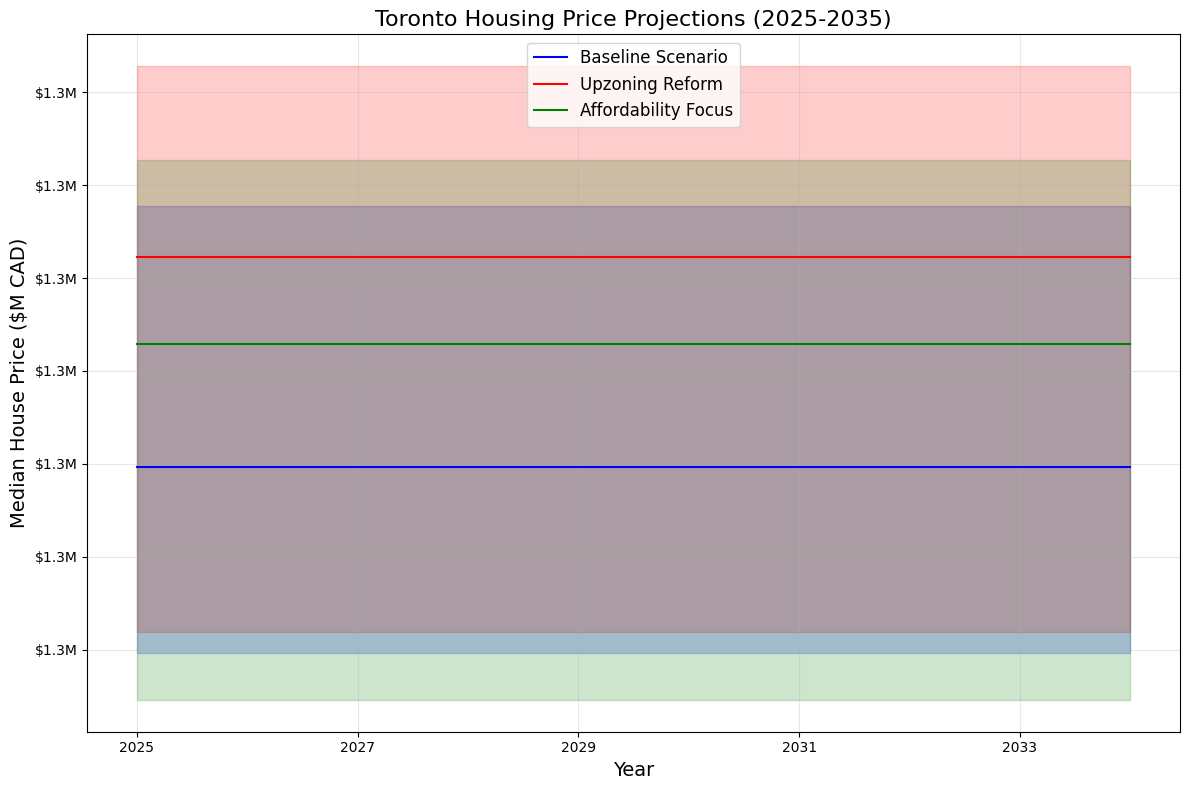

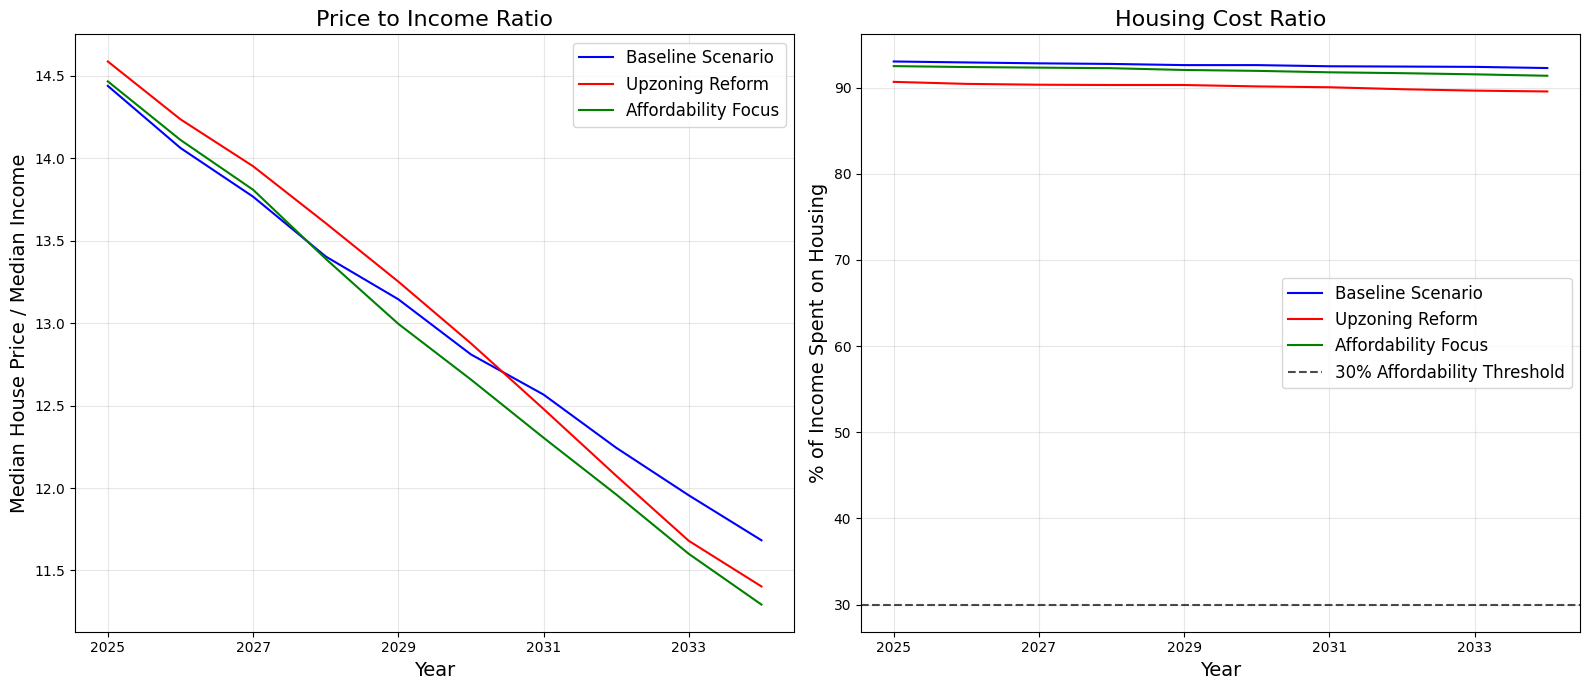

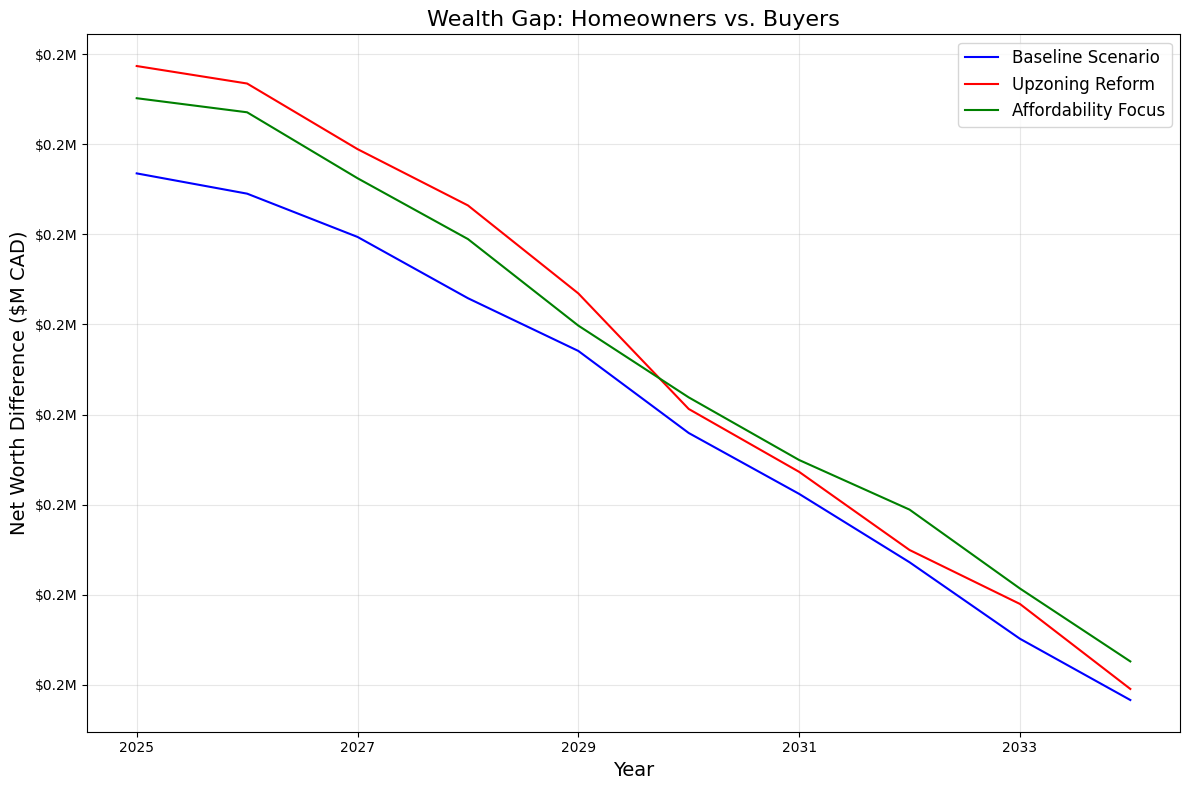

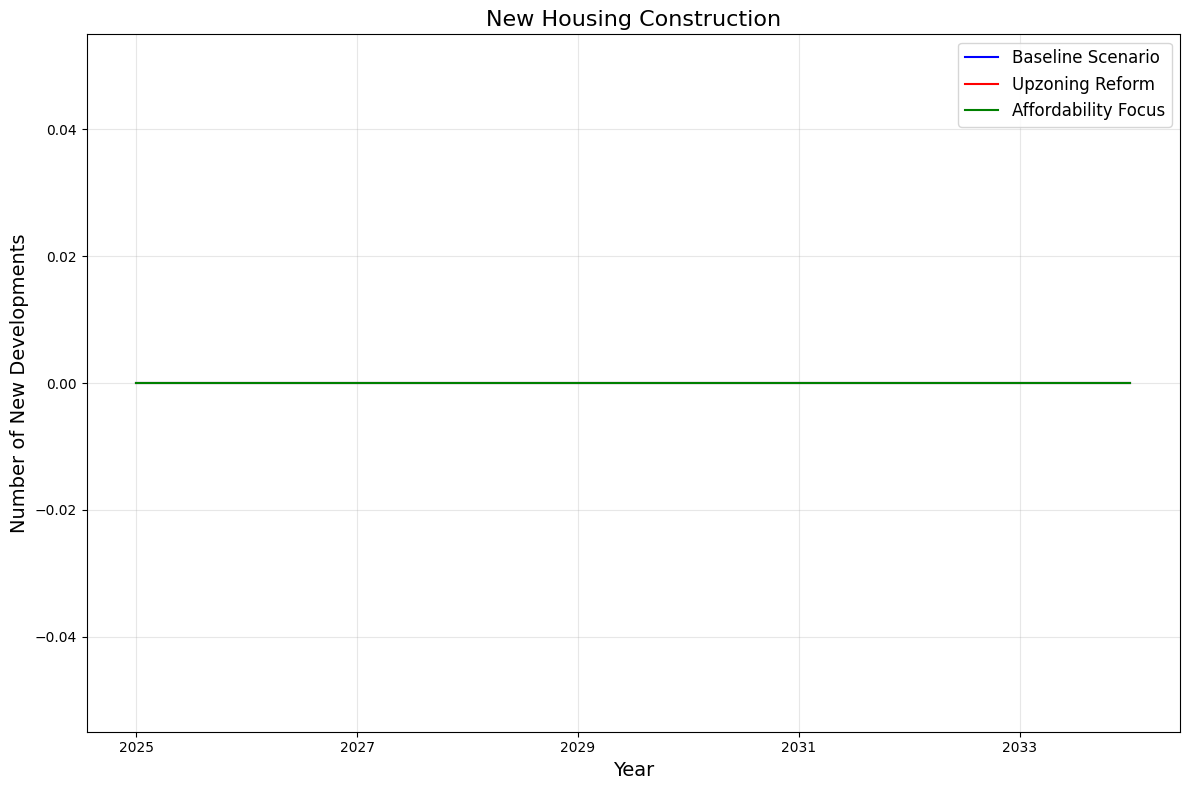

In [63]:
# Visualization functions
def plot_price_trajectories(baseline, upzoning, affordability):
    """Plot price trajectories for different scenarios with uncertainty bands"""
    years = baseline["years"]
    
    plt.figure(figsize=(12, 8))
    
    # Baseline scenario
    plt.plot(years, baseline["median_price_median"] / 1000000, 'b-', label='Baseline Scenario')
    plt.fill_between(years, 
                     baseline["median_price_10th"] / 1000000, 
                     baseline["median_price_90th"] / 1000000, 
                     alpha=0.2, color='blue')
    
    # Upzoning scenario
    plt.plot(years, upzoning["median_price_median"] / 1000000, 'r-', label='Upzoning Reform')
    plt.fill_between(years, 
                     upzoning["median_price_10th"] / 1000000, 
                     upzoning["median_price_90th"] / 1000000, 
                     alpha=0.2, color='red')
    
    # Affordability scenario
    plt.plot(years, affordability["median_price_median"] / 1000000, 'g-', label='Affordability Focus')
    plt.fill_between(years, 
                     affordability["median_price_10th"] / 1000000, 
                     affordability["median_price_90th"] / 1000000, 
                     alpha=0.2, color='green')
    
    plt.title('Toronto Housing Price Projections (2025-2035)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Median House Price ($M CAD)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(years[::2])  # Show every other year
    
    # Format y-axis as millions
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.1f}M'))
    
    plt.tight_layout()
    plt.show()

def plot_affordability_metrics(baseline, upzoning, affordability):
    """Plot affordability metrics for different scenarios"""
    years = baseline["years"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Price to Income Ratio
    ax1.plot(years, baseline["price_to_income_ratio_median"], 'b-', label='Baseline Scenario')
    ax1.plot(years, upzoning["price_to_income_ratio_median"], 'r-', label='Upzoning Reform')
    ax1.plot(years, affordability["price_to_income_ratio_median"], 'g-', label='Affordability Focus')
    
    ax1.set_title('Price to Income Ratio', fontsize=16)
    ax1.set_xlabel('Year', fontsize=14)
    ax1.set_ylabel('Median House Price / Median Income', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    ax1.set_xticks(years[::2])
    
    # Housing Cost Ratio (% of income spent on housing)
    ax2.plot(years, baseline["affordability_ratio_median"] * 100, 'b-', label='Baseline Scenario')
    ax2.plot(years, upzoning["affordability_ratio_median"] * 100, 'r-', label='Upzoning Reform')
    ax2.plot(years, affordability["affordability_ratio_median"] * 100, 'g-', label='Affordability Focus')
    
    # Add 30% threshold line
    ax2.axhline(y=30, color='k', linestyle='--', alpha=0.7, label='30% Affordability Threshold')
    
    ax2.set_title('Housing Cost Ratio', fontsize=16)
    ax2.set_xlabel('Year', fontsize=14)
    ax2.set_ylabel('% of Income Spent on Housing', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)
    ax2.set_xticks(years[::2])
    
    plt.tight_layout()
    plt.show()

def plot_wealth_gap(baseline, upzoning, affordability):
    """Plot wealth gap between homeowners and buyers"""
    years = baseline["years"]
    
    plt.figure(figsize=(12, 8))
    
    # Calculate wealth gaps
    baseline_gap = baseline["homeowner_net_worth_median"] - baseline["buyer_net_worth_median"]
    upzoning_gap = upzoning["homeowner_net_worth_median"] - upzoning["buyer_net_worth_median"]
    affordability_gap = affordability["homeowner_net_worth_median"] - affordability["buyer_net_worth_median"]
    
    plt.plot(years, baseline_gap / 1000000, 'b-', label='Baseline Scenario')
    plt.plot(years, upzoning_gap / 1000000, 'r-', label='Upzoning Reform')
    plt.plot(years, affordability_gap / 1000000, 'g-', label='Affordability Focus')
    
    plt.title('Wealth Gap: Homeowners vs. Buyers', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Net Worth Difference ($M CAD)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(years[::2])
    
    # Format y-axis as millions
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.1f}M'))
    
    plt.tight_layout()
    plt.show()

def plot_construction_activity(baseline, upzoning, affordability):
    """Plot new construction activity"""
    years = baseline["years"]
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(years, baseline["new_construction_median"], 'b-', label='Baseline Scenario')
    plt.plot(years, upzoning["new_construction_median"], 'r-', label='Upzoning Reform')
    plt.plot(years, affordability["new_construction_median"], 'g-', label='Affordability Focus')
    
    plt.title('New Housing Construction', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of New Developments', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(years[::2])
    
    plt.tight_layout()
    plt.show()

# Generate all visualizations
print("Generating visualizations...")
plot_price_trajectories(baseline_results, upzoning_results, affordability_results)
plot_affordability_metrics(baseline_results, upzoning_results, affordability_results)
plot_wealth_gap(baseline_results, upzoning_results, affordability_results)
plot_construction_activity(baseline_results, upzoning_results, affordability_results)

In [64]:
def generate_summary_report(baseline, upzoning, affordability):
    """Generate a summary report of key metrics"""
    # Calculate final year metrics
    final_year_idx = -1
    
    print("=" * 80)
    print("TORONTO HOUSING AFFORDABILITY SIMULATION - SUMMARY REPORT")
    print("=" * 80)
    print(f"Simulation Period: 2025-2035 ({NUM_YEARS} years)")
    print(f"Number of Realizations: {NUM_REALIZATIONS}")
    print("=" * 80)
    
    # Price changes
    print("\nMEDIAN HOUSE PRICES (Final Year - 2035)")
    print("-" * 50)
    baseline_price = baseline["median_price_median"][final_year_idx] / 1000000
    upzoning_price = upzoning["median_price_median"][final_year_idx] / 1000000
    affordability_price = affordability["median_price_median"][final_year_idx] / 1000000
    
    print(f"Baseline Scenario:     ${baseline_price:.2f}M")
    print(f"Upzoning Reform:       ${upzoning_price:.2f}M ({(upzoning_price-baseline_price)/baseline_price*100:.1f}% vs Baseline)")
    print(f"Affordability Focus:   ${affordability_price:.2f}M ({(affordability_price-baseline_price)/baseline_price*100:.1f}% vs Baseline)")
    
    # Affordability metrics
    print("\nAFFORDABILITY METRICS (Final Year - 2035)")
    print("-" * 50)
    print("Housing Cost Ratio (% of income spent on housing):")
    print(f"Baseline Scenario:     {baseline['affordability_ratio_median'][final_year_idx]*100:.1f}%")
    print(f"Upzoning Reform:       {upzoning['affordability_ratio_median'][final_year_idx]*100:.1f}%")
    print(f"Affordability Focus:   {affordability['affordability_ratio_median'][final_year_idx]*100:.1f}%")
    
    print("\nPrice to Income Ratio:")
    print(f"Baseline Scenario:     {baseline['price_to_income_ratio_median'][final_year_idx]:.1f}x")
    print(f"Upzoning Reform:       {upzoning['price_to_income_ratio_median'][final_year_idx]:.1f}x")
    print(f"Affordability Focus:   {affordability['price_to_income_ratio_median'][final_year_idx]:.1f}x")
    
    # Wealth gap
    print("\nWEALTH GAP (Final Year - 2035)")
    print("-" * 50)
    baseline_gap = (baseline["homeowner_net_worth_median"][final_year_idx] - baseline["buyer_net_worth_median"][final_year_idx]) / 1000000
    upzoning_gap = (upzoning["homeowner_net_worth_median"][final_year_idx] - upzoning["buyer_net_worth_median"][final_year_idx]) / 1000000
    affordability_gap = (affordability["homeowner_net_worth_median"][final_year_idx] - affordability["buyer_net_worth_median"][final_year_idx]) / 1000000
    
    print(f"Baseline Scenario:     ${baseline_gap:.2f}M")
    print(f"Upzoning Reform:       ${upzoning_gap:.2f}M ({(upzoning_gap-baseline_gap)/baseline_gap*100:.1f}% vs Baseline)")
    print(f"Affordability Focus:   ${affordability_gap:.2f}M ({(affordability_gap-baseline_gap)/baseline_gap*100:.1f}% vs Baseline)")
    
    # Construction activity
    print("\nCUMULATIVE NEW CONSTRUCTION (2025-2035)")
    print("-" * 50)
    baseline_construction = np.sum(baseline["new_construction_median"])
    upzoning_construction = np.sum(upzoning["new_construction_median"])
    affordability_construction = np.sum(affordability["new_construction_median"])
    
    print(f"Baseline Scenario:     {baseline_construction:.0f} units")
    print(f"Upzoning Reform:       {upzoning_construction:.0f} units ({(upzoning_construction-baseline_construction)/baseline_construction*100:.1f}% vs Baseline)")
    print(f"Affordability Focus:   {affordability_construction:.0f} units ({(affordability_construction-baseline_construction)/baseline_construction*100:.1f}% vs Baseline)")
    
    print("=" * 80)
    print("END OF REPORT")
    print("=" * 80)

# Generate summary report
generate_summary_report(baseline_results, upzoning_results, affordability_results)

TORONTO HOUSING AFFORDABILITY SIMULATION - SUMMARY REPORT
Simulation Period: 2025-2035 (10 years)
Number of Realizations: 100

MEDIAN HOUSE PRICES (Final Year - 2035)
--------------------------------------------------
Baseline Scenario:     $1.26M
Upzoning Reform:       $1.27M (0.4% vs Baseline)
Affordability Focus:   $1.26M (0.3% vs Baseline)

AFFORDABILITY METRICS (Final Year - 2035)
--------------------------------------------------
Housing Cost Ratio (% of income spent on housing):
Baseline Scenario:     92.3%
Upzoning Reform:       89.6%
Affordability Focus:   91.4%

Price to Income Ratio:
Baseline Scenario:     11.7x
Upzoning Reform:       11.4x
Affordability Focus:   11.3x

WEALTH GAP (Final Year - 2035)
--------------------------------------------------
Baseline Scenario:     $0.22M
Upzoning Reform:       $0.22M (0.1% vs Baseline)
Affordability Focus:   $0.22M (0.5% vs Baseline)

CUMULATIVE NEW CONSTRUCTION (2025-2035)
--------------------------------------------------
Baseline

/tmp/ipykernel_122634/1207082209.py:56: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Upzoning Reform:       {upzoning_construction:.0f} units ({(upzoning_construction-baseline_construction)/baseline_construction*100:.1f}% vs Baseline)")
/tmp/ipykernel_122634/1207082209.py:57: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Affordability Focus:   {affordability_construction:.0f} units ({(affordability_construction-baseline_construction)/baseline_construction*100:.1f}% vs Baseline)")
